Implement the model in this paper: https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf
but character level LM
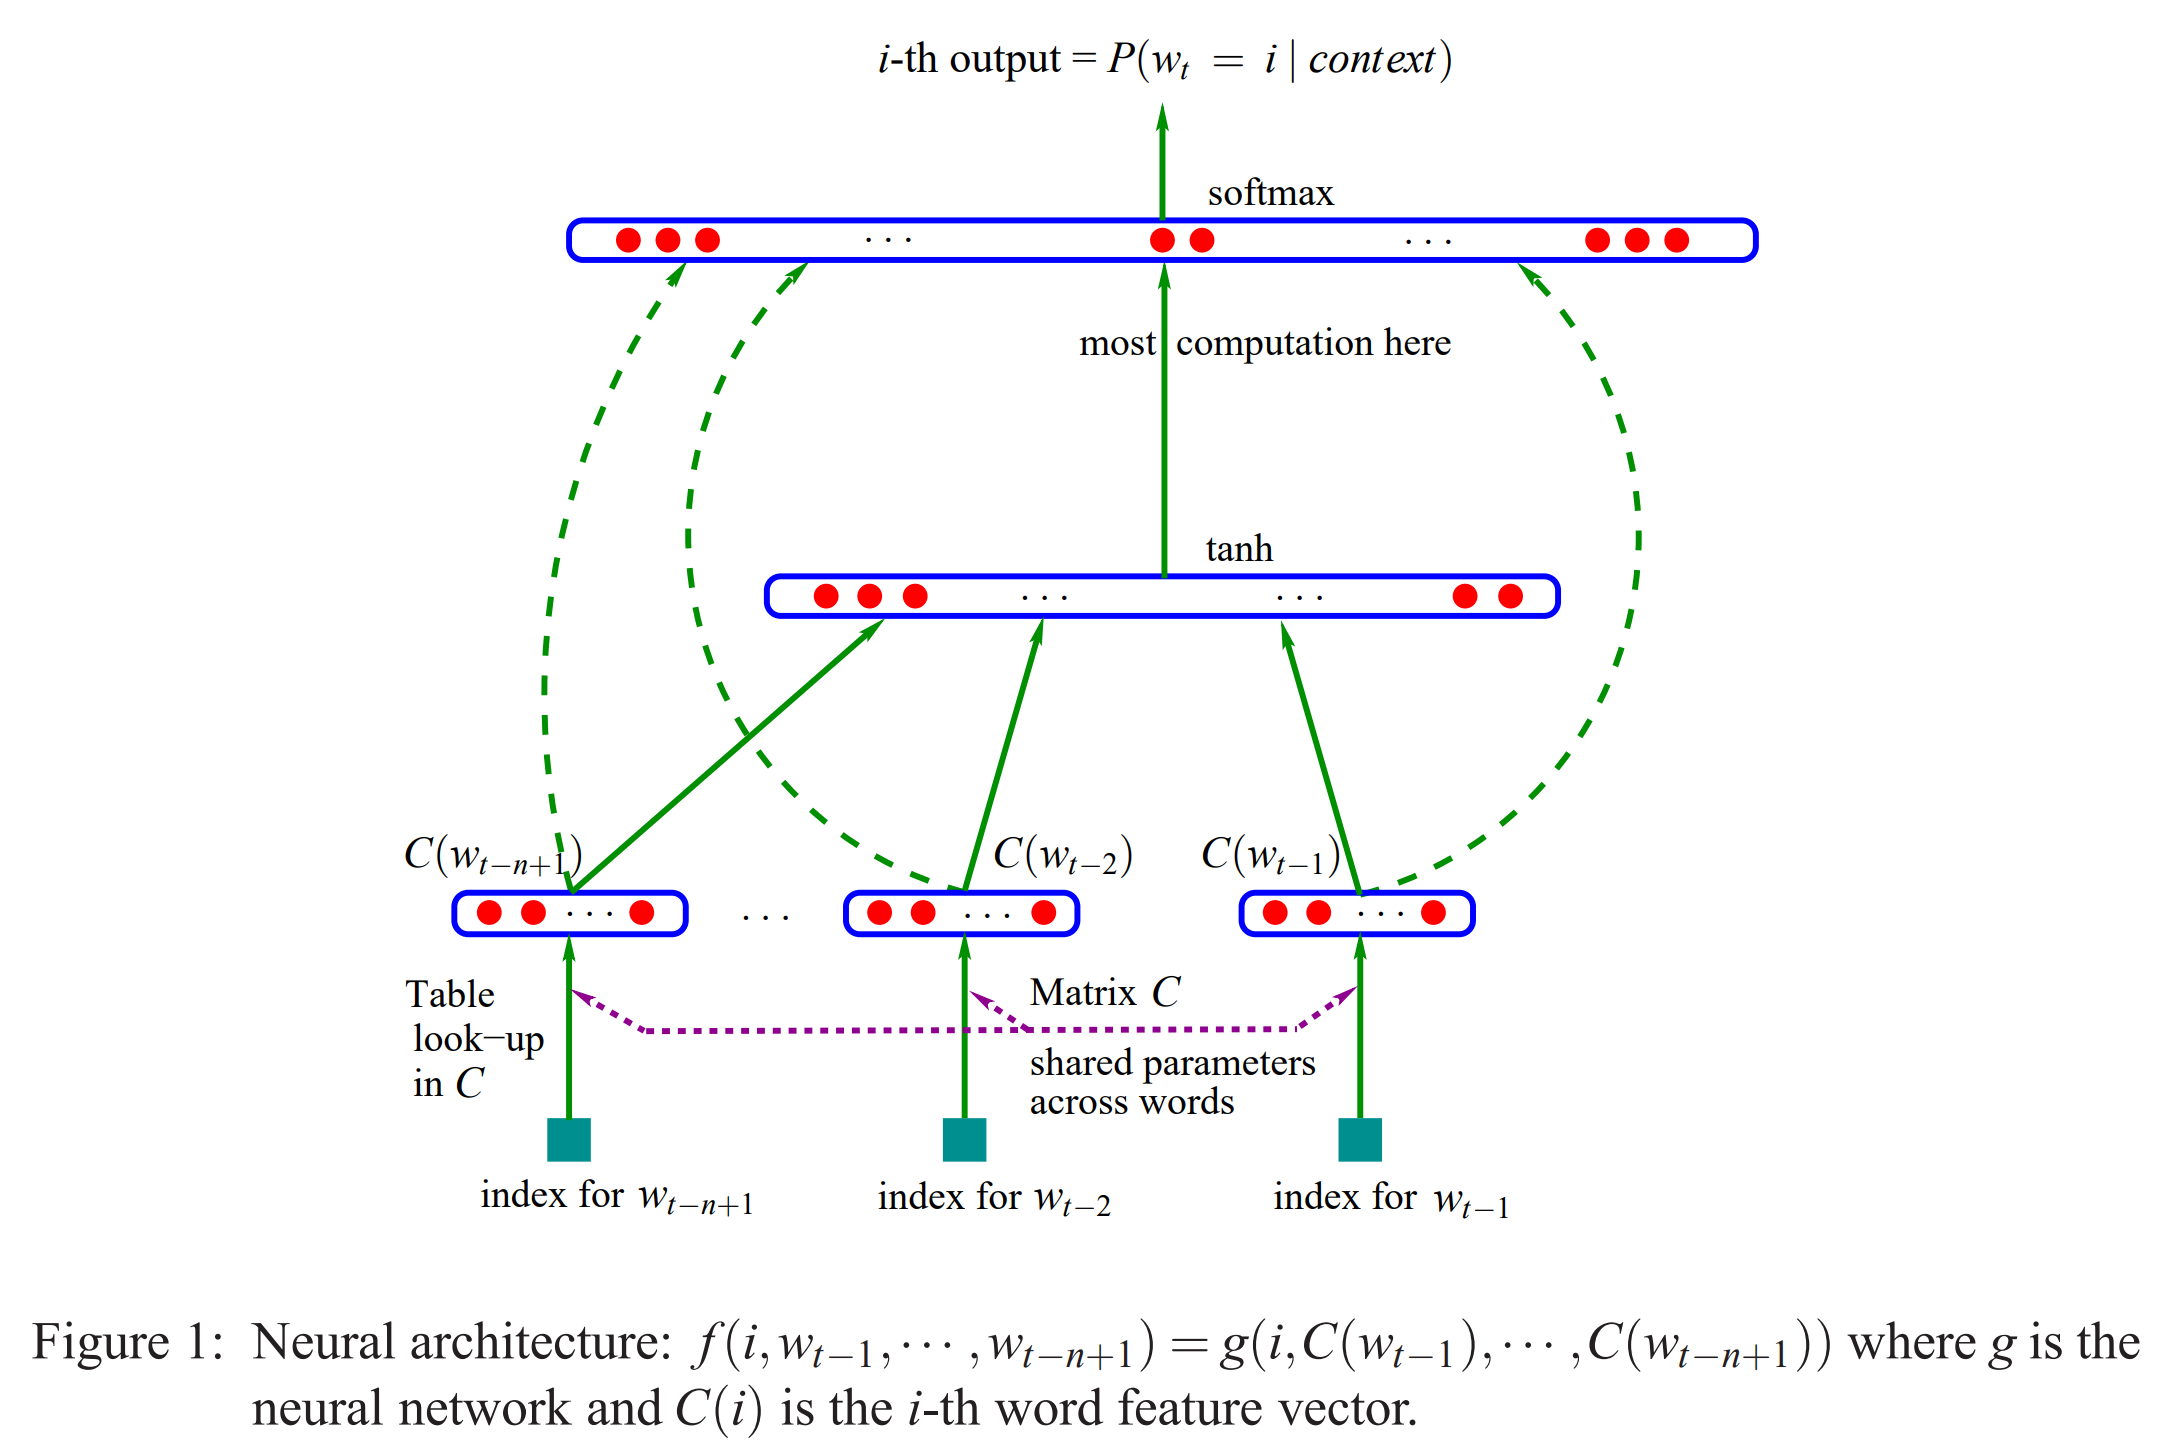

## Imports

In [1]:
import torch
import torch.nn.functional as F

## Build vocabulary and mappings

In [9]:
chr(97)

'a'

In [10]:
0 + ord('a')

97

In [11]:
vocab = [] # all poosible characters in the training corpus
itoc = {} # index to character mapping
ctoi = {} # character to index mapping
for i in range(26):
    c = chr(i+ord('a'))
    vocab.append(c)
    ctoi[c] = i+1
    itoc[i+1] = c

vocab.append('.')
itoc[0] = '.'
ctoi['.'] = 0

In [14]:
'|'.join(vocab)

'a|b|c|d|e|f|g|h|i|j|k|l|m|n|o|p|q|r|s|t|u|v|w|x|y|z|.'

## load data and create train, val, test splits

In [21]:
X = []
y = []
block_size = 3 # previous context size
with open('./names.txt', 'r') as f:
    for name in f.readlines()[:5]:
        context = [0]*block_size # initialize previous context of each word with '...', which translates to [0,0,0] indices in the vocab
        for c in name.strip() + '.': # append '.' to the end of name to capture ending sequences of each name
            label = ctoi[c] # vocab index of the current character in name
            print(''.join([itoc[i] for i in context]), "--->", c) # verify how data looks
            X.append(context)
            y.append(label)
            context = context[1:] + [label]

# in this case '.' is our start/stop special token

... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
... ---> a
..a ---> v
.av ---> a
ava ---> .
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [25]:
X = torch.tensor(X)
y = torch.tensor(y)
X.shape, y.shape

(torch.Size([32, 3]), torch.Size([32]))

## Build the NN
- start with the feature mapping C
- map the X[i] to C(X[i]) where X[i] represents "block_size" number of characters
- hidden layer with tanh activation function
- output layer with softmax
- negative log likelihood (NLL) loss

In [28]:
# initialize the feature vector mapping from vocab index to some low dimensional feature space (embedding)
# start with 2d space
feature_vector_dimensions = 2
vocab_size = len(vocab)
C = torch.randn((vocab_size, feature_vector_dimensions)) # random features drawn from normal distribution
C.shape

torch.Size([27, 2])

### tensor indexing

In [30]:
# tensor indexing
C[0] # picks the 1st row (or 1st element (which is vector here) along 1st the axis (axis 0))

tensor([-0.0634, -0.1353])

In [33]:
C[0, 1] # picks the 2nd column of 1st row 

tensor(-0.1353)

In [34]:
C[[0,1]] # picks the 1st and 2nd row

tensor([[-0.0634, -0.1353],
        [-1.1484, -0.0377]])

In [35]:
C[torch.tensor([0,1])] # same as above tensor can be passed

tensor([[-0.0634, -0.1353],
        [-1.1484, -0.0377]])

In [41]:
C[:,0] # picks 1st column - take all 1st column elements from each row

tensor([-0.0634, -1.1484, -1.0419, -1.2626,  0.3297, -0.6820, -1.0115, -0.3552,
         0.0089,  1.9386, -2.5692, -0.9587, -0.1879, -1.4279, -1.5221, -0.3937,
         0.8174, -2.2602, -2.9813, -0.4418,  0.2252,  0.2437,  1.6786, -0.1664,
        -1.1537, -0.0730,  0.6999])

In [42]:
C[1,:] # picks 2nd row - take all 2nd row elements from each column
# same as C[1]

tensor([-1.1484, -0.0377])

### tensor concat, unbind and view

In [39]:
# embed the first example
emb = C[X[0]]
emb, emb.shape

(tensor([[-0.0634, -0.1353],
         [-0.0634, -0.1353],
         [-0.0634, -0.1353]]),
 torch.Size([3, 2]))

In [40]:
# embed all examples [mini batch of 32 here is the entire training set]
emb = C[X]
emb.shape # 32 training examples, 3 tokens (chars here) as input, embedding dimension = 2

torch.Size([32, 3, 2])

- next (hidden) layer in NN would take these embeddings as input
- Now all layers in Multi-Layer Perceptron consist of a stack of neurons with 1D tensors as input and output
- currently our input is 2D with size (block_size, embed_dimension) for each of the 32 training examples
- flatten them into 1D tensor of size block_size * embed_dimension
- the input is essentially 3 embeddings placed side-by-side as a single 1D input layer [see diagram in 1st cell]

In [45]:
emb[:,0,:].shape # picks the first token embedding for all the examples

torch.Size([32, 2])

In [48]:
# concat the 3 tensors corresponding to 3 tokens horizontally into axis 1
input = torch.concat([emb[:,0,:], emb[:,1,:], emb[:,2,:]], dim = 1)
input.shape

torch.Size([32, 6])

- the above technique isn't robust to changes in block_size
- generalize the concatenation using unbind

In [57]:
# unbind literally unbinds the tensor along a particular dimension and gives N individual tensors, where N is size of that dimension
unb = torch.unbind(emb, dim = 1)
len(unb), unb[0].shape, unb[1].shape, unb[2].shape #, ... unb[N-1].shape

(3, torch.Size([32, 2]), torch.Size([32, 2]), torch.Size([32, 2]))

In [59]:
# now we can concat in a robust way - non-dependance on block_size
input = torch.concat(torch.unbind(emb, dim = 1), dim = 1)
input.shape

torch.Size([32, 6])

- above technique is still inefficent as both unbind and concat create new tensors from input tensors consuming memory
- hence, use tensor view operation to change the structure of existing tensor
- view rearranges the tensor elements by utilizing storage locations [read http://blog.ezyang.com/2019/05/pytorch-internals/]

In [63]:
emb.view(32, 6).shape # explicit setting

torch.Size([32, 6])

In [65]:
emb.view(32, -1).shape # -1 implies figure it out yourself, PyTorch implicitly derives -1 given the other dimensions

torch.Size([32, 6])

In [66]:
emb.view(-1, 2).shape

torch.Size([96, 2])

In [67]:
emb.view(1, -1).shape

torch.Size([1, 192])

In [69]:
print("View shape: ", emb.view(-1, block_size*feature_vector_dimensions).shape)
print("Original shape is maintained: ", emb.shape)

View shape:  torch.Size([32, 6])
Original shape is maintained:  torch.Size([32, 3, 2])


### implement first hidden layer using view operation

In [71]:
# intialize hyperparameter hidden_layer_size and parameters weights and bias
hidden_layer_size = 100
W1 = torch.randn((block_size*feature_vector_dimensions, hidden_layer_size))
b1 = torch.randn((hidden_layer_size))
W1.shape, b1.shape

(torch.Size([6, 100]), torch.Size([100]))

- here input*weight_matrix would give (32, 100) tensor and b1 is (100)
- broadcasting rules work as follows:
--> 32, 100
--> 1, 100
- rightmost dimensions are matched and replicated along all remaining (left) dimensions
- hence works here as we want the bias to be added to all the examples
- always be careful while broadcasting!!

In [72]:
z1 = emb.view(-1, block_size*feature_vector_dimensions) @ W1 + b1 # hidden layer outputs
ha = torch.tanh(z1) # hidden layer activations
z1.shape, ha.shape

(torch.Size([32, 100]), torch.Size([32, 100]))

### implement output layer

In [75]:
output_layer_size = vocab_size # as we want a probability distribution over the vocabulary
W2 = torch.randn((ha.shape[-1], output_layer_size))
b2 = torch.randn((output_layer_size))
z2 = ha @ W2 + b2
probs = torch.softmax(z2, dim=1)
probs.shape

torch.Size([32, 27])

In [76]:
probs[0] # probability distribution over vocabulary for 1st example, i.e., 
# likelihood of each token in vocabulary coming next in the sequence of block_size [previous 3 words here]

tensor([2.0892e-05, 2.9189e-08, 5.9489e-08, 1.0214e-03, 1.2215e-08, 2.1502e-03,
        6.6317e-04, 1.4577e-02, 4.0847e-07, 4.6152e-08, 1.0655e-03, 2.9755e-04,
        5.1367e-05, 3.1573e-03, 4.2916e-06, 8.4019e-04, 7.2834e-05, 2.2285e-05,
        3.0414e-03, 4.8608e-04, 1.4926e-05, 3.3933e-02, 9.3701e-01, 1.0981e-03,
        4.7255e-04, 7.8586e-07, 4.0401e-07])

In [77]:
# verify that it sums to one as its pdf
torch.sum(probs[0])

tensor(1.0000)